**NDBI048 - Data Science <br>
Author: Ing. Doudou BA <br>
Professor: Doc. RnDr. Irena Holubova, Ph.D. <br>
Charles University <br>
Prague May 2022**

In [137]:
#Contents
#1 Introduction 
#1.1 Assignment . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
#1.2 Methodology . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
#2. Data Understanding 
#2.1. Raw data description . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
#3 Data Preparation 
#3.1 Data Preprocessing - cleaning - Transformation . . . . . . . . . . . . . . . . . . . . . 
#3.2 Data Exploration . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
#3.3 Visualization . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
#4 Modelling 
#5 Evaluation 
#6 Conclusion

## 1. Introduction


In [138]:
import datetime
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import os
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.set_option("display.precision", 2)
plt.rcParams['figure.figsize'] = [8, 6]

In [139]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

 In this report we will explore the Elections dataset. The dataset is provided in two files volby.sav
and **volby.csv** with same contents in SPSS native format.

**• Context:** For the purpose of organizing voting at parliamentary elections, Czech Republic is
split into around 15 thousands small areas called ELECTION DISTRICTS. It should not be
confused with large areas that are also referred to as ”districts.” In a village or generally in
a very small municipality, there can be only one election district for the whole municipality.
In big cities like Prague there are hundreds or maybe more districts within a city. There are
higher levels above municipalities: county (”okres”) and region (”kraj”). So the hierarchy used
in data is: district - municipality - county - region.

**• Voting and valid votes:** In the district room, each eligible voter gets an envelope. He/she
may put a voting sheet into the envelope and throw the envelope into the ballot box. Not
all envelopes may be considered to be valid. So number of envelopes issued >= number of
envelopes inside the box = number of valid votes, but the differences are very small.

**• Parties:** Parties in 2013 and 2017 elections had different numbers and sometimes slightly
different names. The matching of parties between 2013 and 2017 is below.

**• Population descriptors:** Descriptors of population in particular districts comes from the census
2011, so it is considered valid for both election periods (however the reality could change during
these years).

##### 1.1 Scenario

We want to build a model that predicts the **Weights** of political partys given their scores and population information.

##### 1.2 Data collection

The data is collected from trusted sources from dedicated governmental organs.

## 2. Data Understanding 

The Data Preparation include the preprocessing, the cleaning and transformation of raw data to <br>
clean data that will be used as input data in our model. <br>
The Raw data is loaded in Power BI desktop in UTF8 encoding (to enable the reading of special <br>
characters) and using Power query we perform the data tranformation. <br>
The Raw data (dirty data) is as follows: <br>

• Raw data - 18 214 Ko <br>
• Raw data change type <br>
• Raw data 152 col x over 14764 rows <br>
• Raw data long headers names renamed <br>
• Raw data unnecessary columns removed <br>
• Raw data remove duplicates <br>
• Raw data remove blank rows <br>
• Raw data remove errors <br>

In [140]:
#%pip install openpyxl
#%pip install xlrd 
df1= pd.read_csv(r'/Users/dbcooper/Downloads/archive (2)/volby.csv',encoding='latin-1')

##### 2.1 Rows

Election districts in the Czech republic. The district can be identified either by IDN or by ”OBEC
Okrsek” (combination of the municipality code and the district number within the municipality).
Each district is aligned to one municipality, each municipality to one county, each county to one
region

In [141]:
# Print some numbers about data sample size
print(f'Number of rows:   {df1.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {df1.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {df1.shape[1]:,}'.replace(',', ' '))

Number of rows:   14 764
Number of unique indexes:   14 764
Number of columns:   183


In [142]:
# define list of predictors
cols_pred = list(df1.columns[1:-4])
# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if df1[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if df1[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(df1[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(df1[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
OBEC                                                int64
Obec_okrsek_final2016                             float64
PAR_2017_1_ObÄanskÃ.demokratickÃ.strana          float64
PAR_2017_2_Å.Ã.dnÃ.rodaVlasteneckÃ.unie           float64
PAR_2017_3_CESTAODPOVÄDNÃ.SPOLEÄNOSTI           float64
PAR_2017_4_ÄeskÃ.str.sociÃ.lnÄ.demokrat          float64
PAR_2017_5_VoltePr.Blokwww.cibulka.net            float64
PAR_2017_6_RadostnÃ.Äesko                        float64
PAR_2017_7_STAROSTOVÃ.ANEZÃ.VISLÃ                float64
PAR_2017_8_KomunistickÃ.str.ÄechaMoravy          float64
PAR_2017_9_StranazelenÃ.ch                        float64
PAR_2017_10_ROZUMNÃstopmigracidiktÃ.t.EU         float64
PAR_2017_11_SpoleÄ.protivÃ.st.vProk.ÃºdolÃ.      float64
PAR_2017_12_StranasvobodnÃ.chobÄanÅ¯             float64
PAR_2017_13_Blokprotiislam.Obran.domova           float64
PAR_2017_14_ObÄanskÃ.demokratickÃ.aliance        float64
PAR_2017_15_ÄeskÃ.pirÃ.tskÃ

##### 2.2 Matching of the parties 2013-2017

The matching is in this structure: Party standard abbreviation, number 2013, number 2017. CSSD,
1, 4 SSO, 2, 12 PIR, 3, 15 TOP, 4, 20 ODS, 6, 1 KDU, 11, 24 PRBL, 12, 5 SPO, 15, 30 SPD, 17,
29 DSSS, 18, 28 ANO, 20, 21 KSCM, 21, 8 SZ, 23, 9. Other parties did not attend both elections
or their results were negligible.
The data collected in a zip format is extracted and saved in a csv format.

We drop variables that have more than 70% missing values.
We end up with a dataset of:
Number of rows: 14 764 Number of unique indexes: 14 764 Number of columns: 88
We identify columns with infinity, negative or NaN values on our data set and we replace them
with 9999 or 0.

In [143]:
# Importing clean data
data=pd.read_excel(r"/Users/dbcooper/Downloads/clean_data.xlsx")
data.head()

,ID_N,municiality_code,municipality_name,District_name,Region,municipality_District_code,municipality_District,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total,Eligible_voters_17,Envelopes_count_17,Valid_votes_count_17,P1_13,P2_13,P3_13,P4_13,P5_13,P6_13,P7_13,P8_13,P9_13,P10_13,P11_13,P12_13,P13_13,P14_13,P15_13,P16_13,P17_13,P18_13,P19_13,P20_13,P21_13,P22_13,P24_13,Eligible_voters_13,Envelopes_count_13,Valid_votes_count_13,Count_of_buildings,Population_District,Male,Female,Divorced,children_under_14,65y0plus,RomaPeople,University,edu_level_5,edu_level_4,edu_level_3,edu_level_2,edulevel_1,Catholics,Employed,Retired_Working_part,Unemployed,Retired_not_working,Weight
0,35,529478,Čakov,Benešov,Středočeský kraj,5.29e+06,529478_1,7.0,0.0,0.0,6.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,8.0,15.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,71.0,93.0,71.0,71.0,10.0,2.0,3.0,15.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,10.0,7.0,0.0,1.0,0.0,99.0,68.0,67.0,34.0,121.0,60.0,61.0,6.0,21.0,21.0,0.0,9.0,1.0,2.0,32.0,28.0,25.0,26.0,47.0,9.0,9.0,26.0,0.17
1,38,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_3,6.0,0.0,0.0,2.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,31.0,44.0,31.0,31.0,9.0,0.0,5.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,1.0,0.0,48.0,32.0,32.0,16.0,45.0,24.0,21.0,3.0,1.0,13.0,0.0,2.0,0.0,1.0,8.0,21.0,12.0,6.0,18.0,6.0,0.0,16.0,0.08
2,39,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_4,3.0,0.0,0.0,2.0,0.0,0.0,3.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,25.0,0.0,1.0,6.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,57.0,65.0,57.0,57.0,10.0,0.0,2.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,2.0,0.0,69.0,43.0,43.0,31.0,82.0,33.0,49.0,0.0,9.0,20.0,0.0,3.0,1.0,1.0,20.0,30.0,16.0,19.0,33.0,3.0,1.0,28.0,0.12
3,41,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_6,1.0,0.0,0.0,6.0,0.0,0.0,5.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,49.0,79.0,50.0,49.0,14.0,0.0,1.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,9.0,12.0,0.0,1.0,0.0,85.0,59.0,58.0,34.0,110.0,51.0,59.0,6.0,22.0,20.0,0.0,8.0,1.0,3.0,23.0,35.0,15.0,18.0,47.0,1.0,2.0,26.0,0.15
4,51,529621,Divišov,Benešov,Středočeský kraj,5.30e+06,529621_5,1.0,0.0,0.0,3.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,2.0,22.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,63.0,97.0,63.0,63.0,6.0,0.0,4.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,12.0,16.0,0.0,2.0,0.0,98.0,60.0,60.0,27.0,100.0,48.0,52.0,13.0,13.0,15.0,0.0,3.0,1.0,1.0,20.0,30.0,30.0,12.0,42.0,7.0,6.0,24.0,0.17


In [144]:
desc=data.describe()
desc

,ID_N,municiality_code,municipality_District_code,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total,Eligible_voters_17,Envelopes_count_17,Valid_votes_count_17,P1_13,P2_13,P3_13,P4_13,P5_13,P6_13,P7_13,P8_13,P9_13,P10_13,P11_13,P12_13,P13_13,P14_13,P15_13,P16_13,P17_13,P18_13,P19_13,P20_13,P21_13,P22_13,P24_13,Eligible_voters_13,Envelopes_count_13,Valid_votes_count_13,Count_of_buildings,Population_District,Male,Female,Divorced,children_under_14,65y0plus,RomaPeople,University,edu_level_5,edu_level_4,edu_level_3,edu_level_2,edulevel_1,Catholics,Employed,Retired_Working_part,Unemployed,Retired_not_working,Weight
count,14764.00,14764.00,1.37e+04,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,1.47e+04,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,14745.00,13577.00,13577.00,13577.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14730.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14759.00,14764.00
mean,7402.19,557082.91,1.63e+07,38.71,0.59,0.25,24.93,0.03,0.26,17.71,26.64,4.99,2.48,0.03,5.35,0.34,0.54,36.87,0.02,0.03,7.87e-03,0.29,18.01,101.61,0.25,0.67,19.85,0.11,2.43,0.72,0.71,36.47,1.26,0.02,342.19,545.42,333.62,331.42,68.84,8.27,8.95,40.11,1.44,25.95,0.04,0.02,1.93,0.88,22.75,0.08,0.92,0.08,5.08,0.03,23.17,2.91,62.72,50.18,0.26,10.67,0.61,569.59,338.67,335.90,122.92,703.74,344.43,359.31,72.32,100.25,111.26,0.35,75.08,7.88,16.73,163.51,199.25,106.10,73.10,308.75,41.10,33.66,156.08,1.00
std,4282.24,26029.49,2.06e+07,36.24,1.25,0.63,18.75,0.25,0.62,19.30,19.04,5.25,2.49,0.28,5.37,0.72,0.99,32.43,0.18,0.22,1.26e-01,0.71,23.01,69.21,0.84,1.08,22.75,0.39,2.88,1.15,1.25,27.15,1.99,0.17,230.73,392.14,233.78,232.18,49.15,8.13,7.88,42.77,1.96,24.24,0.40,0.18,2.85,1.40,25.07,0.45,1.32,0.35,5.91,0.23,17.97,3.46,45.66,34.82,0.71,11.82,1.08,406.59,227.41,225.54,106.29,483.76,237.47,248.66,59.74,74.16,84.06,4.28,84.30,7.84,13.89,123.20,131.50,75.42,84.27,222.52,33.17,27.80,108.51,0.72
min,1.00,500011.00,5.00e+06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,13.00,9.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,7.00,7.00,1.00,17.00,8.00,8.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,4.00,2.00,0.00,0.00,0.00,0.00,3.00,0.00
25%,3691.75,541231.00,5.49e+06,10.00,0.00,0.00,9.00,0.00,0.00,6.00,11.00,1.00,1.00,0.00,1.00,0.00,0.00,11.00,0.00,0.00,0.00e+00,0.00,3.00,39.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,14.00,0.00,0.00,128.00,188.00,120.00,119.00,25.00,2.00,3.00,9.00,0.00,7.00,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,1.00,0.00,9.00,1.00,22.25,21.00,0.00,2.00,0.00,201.00,126.00,125.00,41.00,240.00,121.00,119.00,18.00,36.00,37.00,0.00,12.00,2.00,4.00,47.00,82.00,43.00,20.00,101.00,14.00,11.00,56.00,0.35
50%,7397.50,556904.00,5.71e+06,29.00,0.00,0.00,22.00,0.00,0.00,12.00,23.00,3.00,2.00,0.00,4.00,0.00,0.00,29.00,0.00,0.00,0.00e+00,0.00,10.00,95.00,0.00,0.00,13.00,0.00,2.00,0.00,0.00,32.00,1.00,0.00,332.00,510.00,311.00,309.00,61.00,6.00,7.00,26.00,1.00,19.00,0.00,0.00,1.00,0.00,15.00,0.00,0.00,0.00,4.00,0.00,20.00,2.00,58.00,44.00,0.00,7.00,0.00,563.00,330.00,327.00,84.00,696.00,338.00,356.00,59.00,92.00,94.00,0.00,47.00,6.00,14.00,152.00,186.00,94.00,49.00,296.00,35.00,29.00,142.00,0.99
75%,11115.25,577308.00,5.97e+06,57.00,1.00,0.0

In [145]:
# Print some numbers about data sample size
print(f'We end up with a dataset of:')
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

We end up with a dataset of:
Number of rows:   14 764
Number of unique indexes:   14 764
Number of columns:   88


In [146]:
# METADEFINITION
#name of the target column
col_target = "Weight"
# define the list of possible predictors 
cols_pred = list(data.drop(columns = 'Weight').columns)
# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
ID_N                            int64
municiality_code                int64
municipality_District_code    float64
P1_17                         float64
P2_17                         float64
P3_17                         float64
P4_17                         float64
P5_17                         float64
P6_17                         float64
P7_17                         float64
P8_17                         float64
P9_17                         float64
P10_17                        float64
P11_17                        float64
P12_17                        float64
P13_17                        float64
P14_17                        float64
P15_17                        float64
P16_17                        float64
P17_17                        float64
P18_17                        float64
P19_17                        float64
P20_17                        float64
P21_17                        float64
P22_17                        float64
P23_17

##### Dropping variables with more than 70% missing values

In [147]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
morethan_70perct_missing = missing_application_train_data[missing_application_train_data['Percent'] > 70].index
data.drop(columns = morethan_70perct_missing,inplace=True)

#### 2.3. Data Visualization

In [148]:
import re 
df=data

col_val_num=re.findall('(P[0-9_]+)|(edu_level_[0-9]+)'," ".join(df.columns.tolist()))

#col_val_num=re.findall('P[0-9_]+'," ".join(df.columns.tolist()))
col_val_num=[i[0]+i[1] for i in col_val_num]
col_val_num.extend(["Catholics", "University","Employed","Unemployed"])
col_val_num[:5]

['P1_17', 'P2_17', 'P3_17', 'P4_17', 'P5_17']

In [149]:
data.head()

,ID_N,municiality_code,municipality_name,District_name,Region,municipality_District_code,municipality_District,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total,Eligible_voters_17,Envelopes_count_17,Valid_votes_count_17,P1_13,P2_13,P3_13,P4_13,P5_13,P6_13,P7_13,P8_13,P9_13,P10_13,P11_13,P12_13,P13_13,P14_13,P15_13,P16_13,P17_13,P18_13,P19_13,P20_13,P21_13,P22_13,P24_13,Eligible_voters_13,Envelopes_count_13,Valid_votes_count_13,Count_of_buildings,Population_District,Male,Female,Divorced,children_under_14,65y0plus,RomaPeople,University,edu_level_5,edu_level_4,edu_level_3,edu_level_2,edulevel_1,Catholics,Employed,Retired_Working_part,Unemployed,Retired_not_working,Weight
0,35,529478,Čakov,Benešov,Středočeský kraj,5.29e+06,529478_1,7.0,0.0,0.0,6.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,8.0,15.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,71.0,93.0,71.0,71.0,10.0,2.0,3.0,15.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,10.0,7.0,0.0,1.0,0.0,99.0,68.0,67.0,34.0,121.0,60.0,61.0,6.0,21.0,21.0,0.0,9.0,1.0,2.0,32.0,28.0,25.0,26.0,47.0,9.0,9.0,26.0,0.17
1,38,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_3,6.0,0.0,0.0,2.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,31.0,44.0,31.0,31.0,9.0,0.0,5.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,1.0,0.0,48.0,32.0,32.0,16.0,45.0,24.0,21.0,3.0,1.0,13.0,0.0,2.0,0.0,1.0,8.0,21.0,12.0,6.0,18.0,6.0,0.0,16.0,0.08
2,39,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_4,3.0,0.0,0.0,2.0,0.0,0.0,3.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,25.0,0.0,1.0,6.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,57.0,65.0,57.0,57.0,10.0,0.0,2.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,2.0,0.0,69.0,43.0,43.0,31.0,82.0,33.0,49.0,0.0,9.0,20.0,0.0,3.0,1.0,1.0,20.0,30.0,16.0,19.0,33.0,3.0,1.0,28.0,0.12
3,41,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_6,1.0,0.0,0.0,6.0,0.0,0.0,5.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,49.0,79.0,50.0,49.0,14.0,0.0,1.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,9.0,12.0,0.0,1.0,0.0,85.0,59.0,58.0,34.0,110.0,51.0,59.0,6.0,22.0,20.0,0.0,8.0,1.0,3.0,23.0,35.0,15.0,18.0,47.0,1.0,2.0,26.0,0.15
4,51,529621,Divišov,Benešov,Středočeský kraj,5.30e+06,529621_5,1.0,0.0,0.0,3.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,2.0,22.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,63.0,97.0,63.0,63.0,6.0,0.0,4.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,12.0,16.0,0.0,2.0,0.0,98.0,60.0,60.0,27.0,100.0,48.0,52.0,13.0,13.0,15.0,0.0,3.0,1.0,1.0,20.0,30.0,30.0,12.0,42.0,7.0,6.0,24.0,0.17


In [150]:
# Municipality information
df_loc = data.filter("ID_N")

# Election results
df_par17 = data.filter(regex=("(P[0-9_17]+)_17|(ID_N)")).dropna()
df_par13 = data.filter(regex=("(P[0-9_]+)_13|(ID_N)")).dropna()

In [151]:
df_par13.head()

,ID_N,P1_13,P2_13,P3_13,P4_13,P5_13,P6_13,P7_13,P8_13,P9_13,P10_13,P11_13,P12_13,P13_13,P14_13,P15_13,P16_13,P17_13,P18_13,P19_13,P20_13,P21_13,P22_13,P24_13
0,35,10.0,2.0,3.0,15.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,10.0,7.0,0.0,1.0,0.0
1,38,9.0,0.0,5.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,1.0,0.0
2,39,10.0,0.0,2.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,2.0,0.0
3,41,14.0,0.0,1.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,9.0,12.0,0.0,1.0,0.0
4,51,6.0,0.0,4.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,12.0,16.0,0.0,2.0,0.0


In [152]:
col_13=list(df_par13.drop(columns="ID_N").columns)

In [153]:

df_13 = df_par13.melt(id_vars=['ID_N'], var_name='Partys', value_name='score')
df_17 = df_par17.melt(id_vars=['ID_N'], var_name='Partys', value_name='score')
df_13.head(), df_17.head()

(   ID_N Partys  score
 0    35  P1_13   10.0
 1    38  P1_13    9.0
 2    39  P1_13   10.0
 3    41  P1_13   14.0
 4    51  P1_13    6.0,
    ID_N Partys  score
 0    35  P1_17    7.0
 1    38  P1_17    6.0
 2    39  P1_17    3.0
 3    41  P1_17    1.0
 4    51  P1_17    1.0)

In [154]:
grp=df_13.drop(columns="ID_N").groupby(['Partys']).agg(np.sum).sort_values(by=['Partys'], ascending=True)

In [155]:
df_par13.head()

,ID_N,P1_13,P2_13,P3_13,P4_13,P5_13,P6_13,P7_13,P8_13,P9_13,P10_13,P11_13,P12_13,P13_13,P14_13,P15_13,P16_13,P17_13,P18_13,P19_13,P20_13,P21_13,P22_13,P24_13
0,35,10.0,2.0,3.0,15.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,10.0,7.0,0.0,1.0,0.0
1,38,9.0,0.0,5.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,1.0,0.0
2,39,10.0,0.0,2.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,2.0,0.0
3,41,14.0,0.0,1.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,9.0,12.0,0.0,1.0,0.0
4,51,6.0,0.0,4.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,12.0,16.0,0.0,2.0,0.0


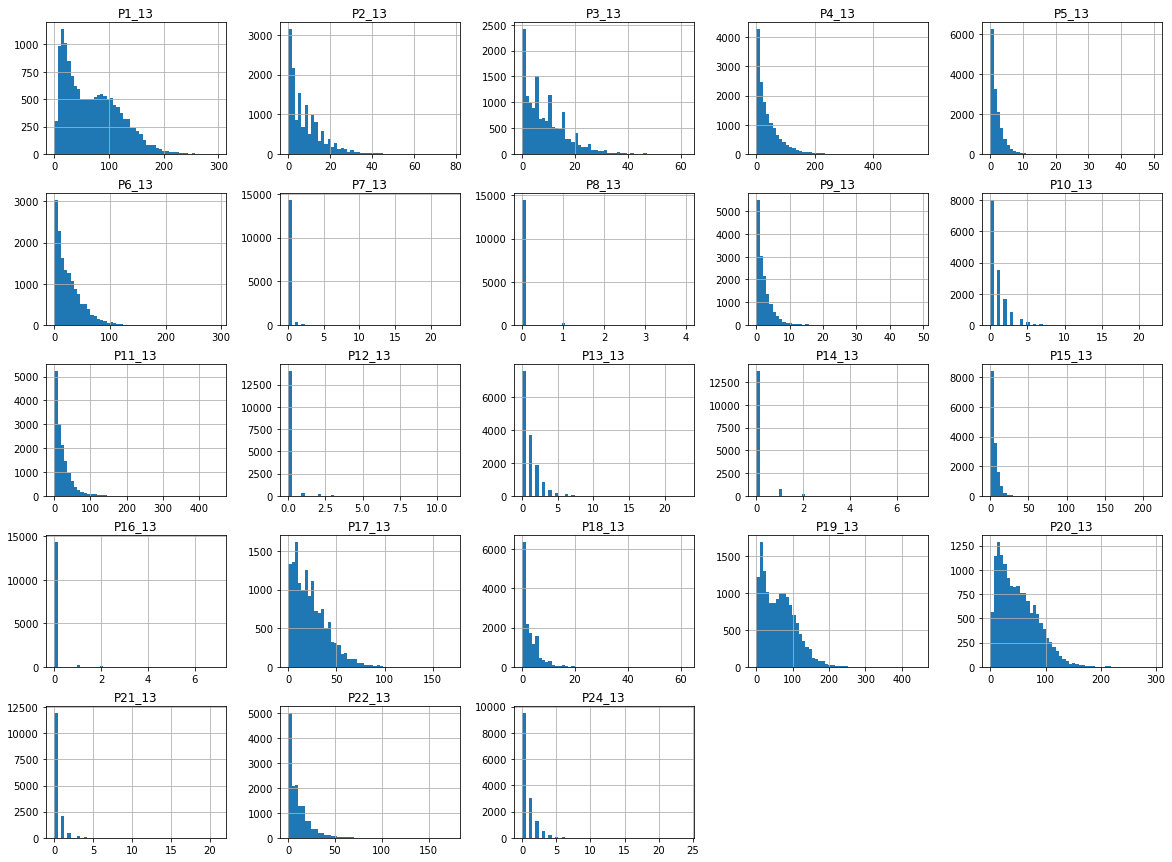

In [156]:
df_par13.drop(columns="ID_N").hist(bins=50, figsize=(20,15))
plt.show()

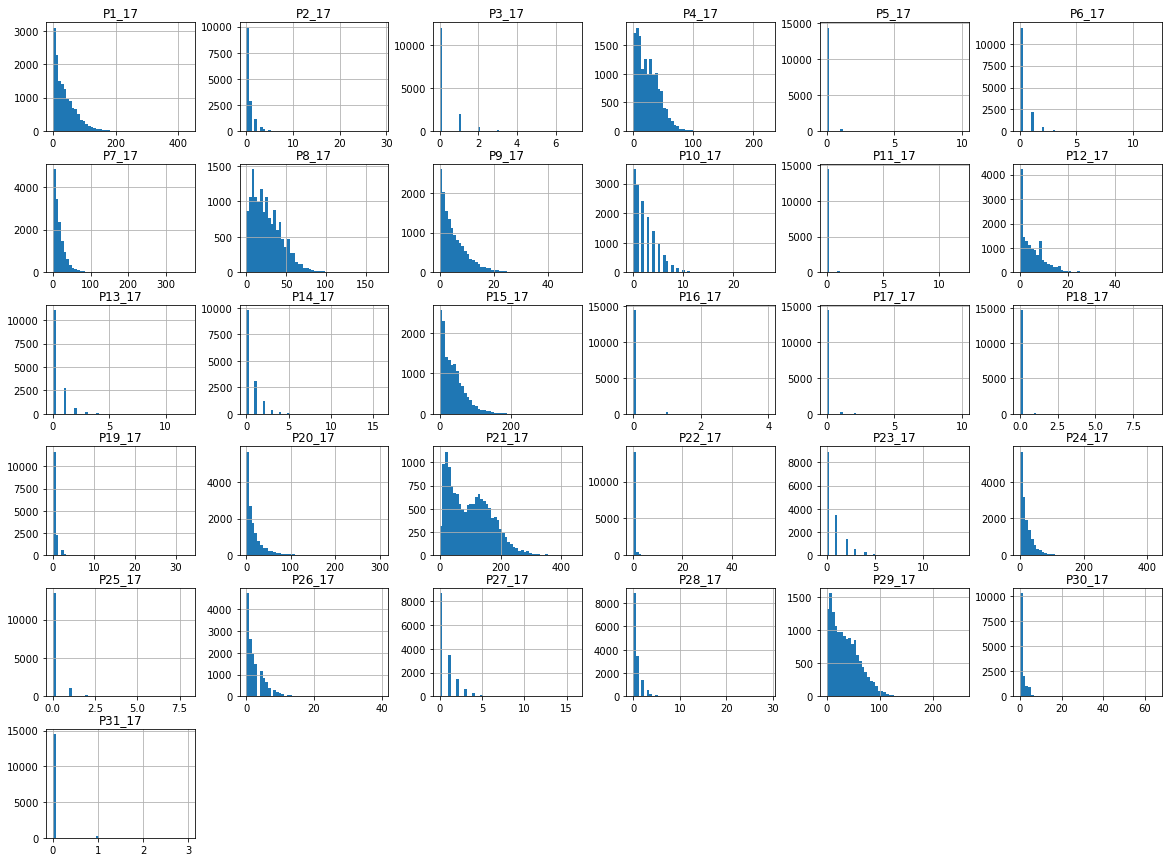

In [157]:
df_par17.drop(columns="ID_N").hist(bins=50, figsize=(20,15))
plt.show()

In [158]:
sex_cols=list(["Male", "Female"])
edu_cols=list(["University",	"edu_level_5", "edu_level_4", "edu_level_3", "edu_level_2", "edulevel_1"])
reli_cols=list(["Catholics"])
employ_cols=list(["Employed", "Retired_Working_part", "Unemployed", "Retired_not_working"])
agg_cols=list(["Male", "Female", "University",	"edu_level_5", "edu_level_4", "edu_level_3", "edu_level_2", "edulevel_1","Catholics","Employed", "Retired_Working_part", "Unemployed", "Retired_not_working"])

In [159]:
grp_13=df_13.drop(columns="ID_N").groupby(df_13["Partys"]).sum().reset_index()
grp_17=df_17.drop(columns="ID_N").groupby(df_17["Partys"]).sum().reset_index()
grp_13.head(), grp_17.head()

(   Partys     score
 0  P10_13   13007.0
 1  P11_13  335140.0
 2  P12_13    1225.0
 3  P13_13   13501.0
 4  P14_13    1222.0,
    Partys    score
 0  P10_17  36498.0
 1  P11_17    431.0
 2  P12_17  78933.0
 3  P13_17   5071.0
 4  P14_17   8013.0)

In [160]:
import matplotlib.pyplot as plt
import numpy as np

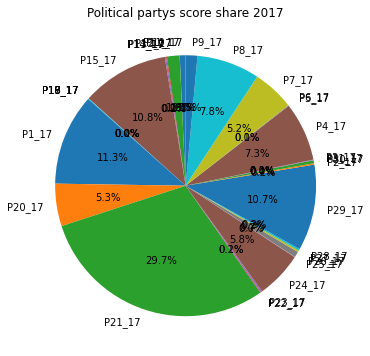

In [161]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = grp_17['Partys']
score = grp_17['score']
fig1, ax1 = plt.subplots()
ax1.pie(score, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.set_title('Political partys score share 2017')
plt.show()

**conclusion**: Party P21 has the biggest score of 29.7% followed by party P1, P15 and P29 with a score of about 11%.<br>
 P8 and P20 and P7 have a score near 5%. The rest is shared by other political partys.

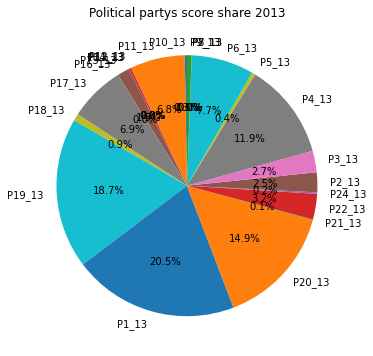

In [162]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = grp_13['Partys']
score = grp_13['score']
fig1, ax1 = plt.subplots()
ax1.pie(score, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.set_title('Political partys score share 2013')
plt.show()

**conclusion**: Party P1 has the biggest score of 20.5% followed by party P19 with a score of 18.7%. The partys P20, P4 with a score of about 11%.<br>
 The rest is shared by other political partys.

Following histograms give us some insight about the distribution of our features.

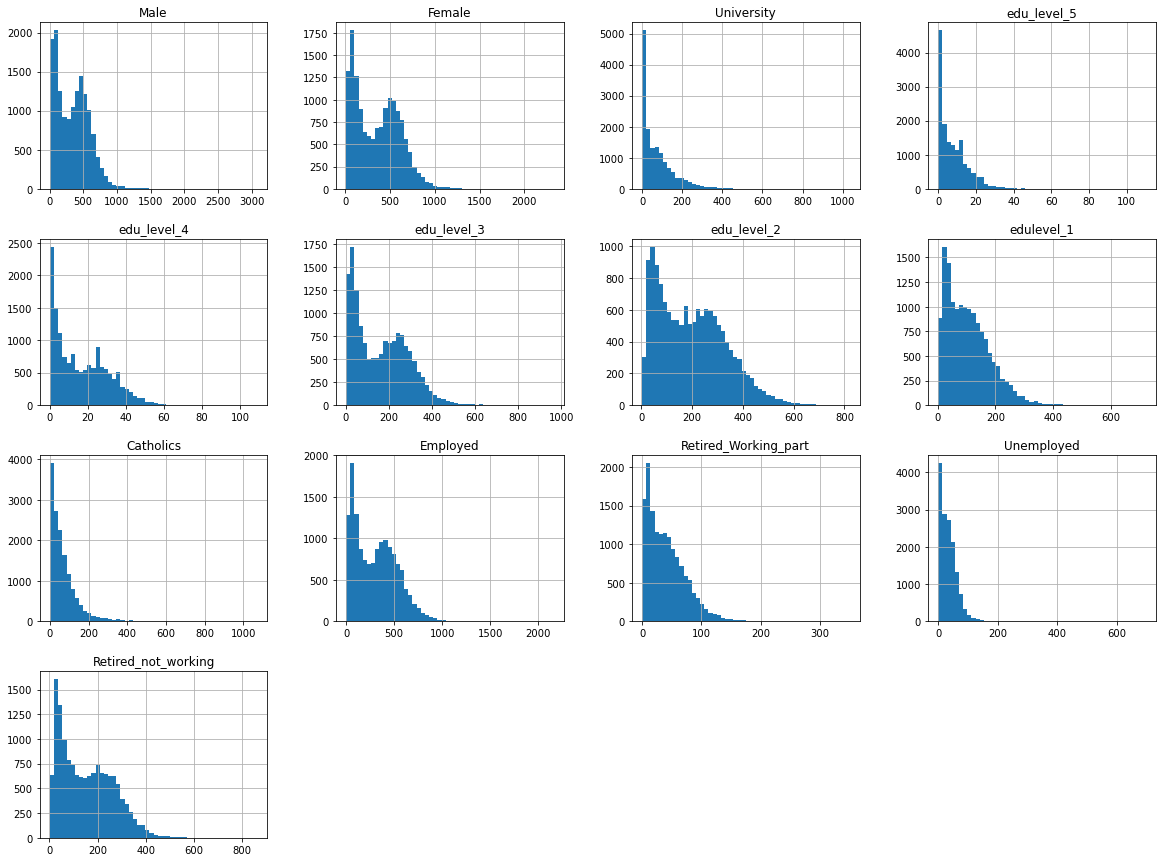

In [163]:
data[agg_cols].hist(bins=50, figsize=(20,15))
plt.show()

##### Distribution of the target column
We want to know how well the target is distibuted

In [164]:
data[col_target].head()

0    0.17
1    0.08
2    0.12
3    0.15
4    0.17
Name: Weight, dtype: float64

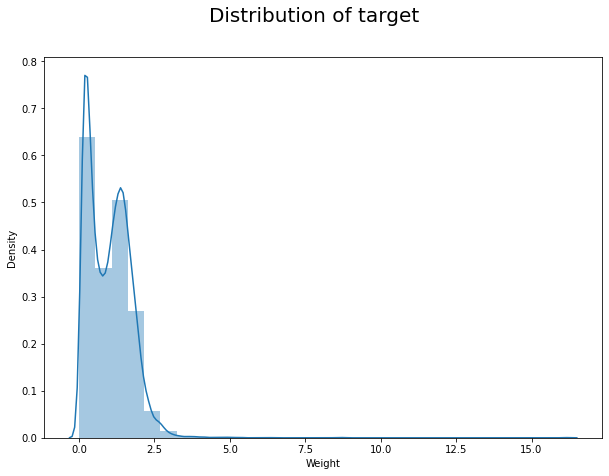

In [165]:
import seaborn as sns

def dist_plot(col):
    plt.figure(figsize=(10,7), facecolor='white')
    sns.distplot(data[col],bins=30,kde=True)
    plt.suptitle("Distribution of target", fontsize=20)
    plt.show()

dist_plot(col_target)

### 2.4. Correlation

 Now let's explore the relationship between political partys and our demographic features

In [166]:
import seaborn as sns
corr_df = data.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

Results show high correlation between educated people and following political partys: P20, P15, P12, P9, P1 (red) which might lead to think (not causality)<br> 
that they have tendency to vote for those particular political partys.
Now we explore the Relationship between religion and decision of voting for a political party
Results show high correlation between catholics and political party P24, which is a catholic party.<br>
Which might lead to think and it is understandable that they vote for P24.
*Now we explore relationship between sexe and decision of voting for a particular political party*
Result:
We found also high correlation between Men as well as Women and  party P29, P21, P15, P12, P8, P4, P1
Divorced People have the same tendency as well as Men and Women.
People of age over 65 would vote for P1, P4, P21  while Roma People seem not have impact to the elections issues
*Relationship between employment status and decision of voting for a particular political party*
Conclusion:
Retired people with part time job have correlation with P15, P20, P1 and P9 while retired without are correlated with P29, P21,P8 and P4
Unemployed people have correlation with for P29, P21, P7 and P4.

The results of the election of Party 1 has a major impact with political partys P20,P21,P15,P12,P9, P7 and P4
They seem to obviously compete for the same voters
Changes of structure of political partys between 2013 and 2017
Results: There is very low corelation for political partys P8, P16, P17, P18 between 2013 and 2017 meaning 
They probably have changes in their structure between 2013 and 2017
General Conclusion:

Overall correlation we noticed that   P24,P29,P20,P21,P15,P12,P9, P7, P4 and P1 are major political partys 
and have chance to win the elections.
We will therefore focus the rest of the analysis on the mentioned political partys

### 3. Data Preparation

##### 3.1 Mean target encoding

We do apply mean target encoding to transform categorical variables into numerical features that we will use as final predictors in our model.

In [167]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, np.mean),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

# METADEFINITION
#name of the target column
col_target = "Weight"
# define the list of possible predictors 
cols_pred = list(data.drop(columns = 'Weight').columns)
# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']



In [168]:
# Save the mean encoding parameters for the test set
list_of_mean_encoding = []
for pred in cols_pred_cat:
    new_vals = mean_target_encoding(
        dt=data, 
        predictor=pred, 
        target=col_target
    )
    list_of_mean_encoding.append([pred,new_vals])
    
# encode categorical predictors
for pred in cols_pred_cat:
    new_vals = mean_target_encoding(
        dt=data, 
        predictor=pred, 
        target=col_target
    )

    additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
    for p in additional_values:
        new_vals[p] = total_dr

    data['MTE_' + pred] = data[pred].replace(new_vals)

    if 'MTE_' + pred not in cols_pred:
        cols_pred.append('MTE_' + pred)

    if pred in cols_pred:
        cols_pred.remove(pred)
        
# Drop all the old categorical variables        
data.drop(columns = cols_pred_cat, inplace = True)


In [169]:
final_predictors = list(data.drop(columns = col_target).columns)

##### 3.2. Finding and replacing infinity values with 9999

We find and remove all inf and NA values and replace them by 99999

In [170]:
# find columns with infinity values
cols_with_inf = []
for col in final_predictors:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')
        
# replace infinity values
for col in cols_with_inf:
    data[col].replace(np.inf, 9999999, inplace = True)  
    
    
# find columns with NEGATIVE infinity values
cols_with_neginf = []
for col in final_predictors:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')
        
# replace NEGATIVE infinity values
for col in cols_with_neginf:
    data[col].replace(np.inf, 9999999, inplace = True)
    
# find columns with NaN values ALL
cols_with_nan = []
for col in final_predictors:
    if np.any(np.isnan(data[col])):
        cols_with_nan.append(col)
        print(f'Column {col} includes NaN values.')
        
        
# replace NaN values
for col in cols_with_nan:
    data[col].replace(np.nan, 9999999, inplace = True)

Column municipality_District_code includes NaN values.
Column P1_17 includes NaN values.
Column P2_17 includes NaN values.
Column P3_17 includes NaN values.
Column P4_17 includes NaN values.
Column P5_17 includes NaN values.
Column P6_17 includes NaN values.
Column P7_17 includes NaN values.
Column P8_17 includes NaN values.
Column P9_17 includes NaN values.
Column P10_17 includes NaN values.
Column P11_17 includes NaN values.
Column P12_17 includes NaN values.
Column P13_17 includes NaN values.
Column P14_17 includes NaN values.
Column P15_17 includes NaN values.
Column P16_17 includes NaN values.
Column P17_17 includes NaN values.
Column P18_17 includes NaN values.
Column P19_17 includes NaN values.
Column P20_17 includes NaN values.
Column P21_17 includes NaN values.
Column P22_17 includes NaN values.
Column P23_17 includes NaN values.
Column P24_17 includes NaN values.
Column P25_17 includes NaN values.
Column P26_17 includes NaN values.
Column P27_17 includes NaN values.
Column P2

In [171]:
print(f'{data.shape[0]} rows and {data.shape[1]} columns')
# Check each column for missing values
print(f'The train set has {data.isna().any().sum()} columns with missing values')

14764 rows and 88 columns
The train set has 0 columns with missing values


##### 3.3. Data Splitting

We know need to split our original dataset into train_set (to train the model) and test_set to evaluate the model and <br> 
the entire orginal data will be used as a validation_set to prove that our model performs well.

In [172]:
# Split the data in train & test
train_set, test_set = train_test_split(data,test_size=0.2,random_state=2)
test_set=test_set.drop(columns=col_target)
train_set.shape, test_set.shape
print(f'The train set has {train_set.shape[0]} rows and {train_set.shape[1]} columns')
# Check each column for missing values
print(f'The train set has {train_set.isna().any().sum()} columns with missing values')
print(f'The test set has {test_set.shape[0]} rows and {test_set.shape[1]} columns')
# Check each column for missing values
print(f'The test set has {test_set.isna().any().sum()} columns with missing values')

The train set has 11811 rows and 88 columns
The train set has 0 columns with missing values
The test set has 2953 rows and 87 columns
The test set has 0 columns with missing values


In [173]:
X=train_set.drop(columns=col_target)
Y=train_set[col_target]
Xtr,Xts,Ytr,Yts = train_test_split(X,Y,test_size=0.2)
# Split the data in train & test
data_train, data_test = train_test_split(data,test_size=0.2,random_state=2)

## 4. Modelling

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [175]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import expon
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
RANDOM_STATE = 12

We build the model we some initial parameters that we will decide to fine tune later.

For this modelling task we are predicting continuous variable synonym to a regression task. There are several models(Linera regression, Random forest, decision Tree regrerssor,...) we could use but we decide to XGBoostRegressor. <br>
The two main reasons to use XGBoost are execution speed and model performance. XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problems.

In [176]:
model = XGBRegressor(n_estimators=100,
                    learning_rate = .1,
                    max_depth = 6,
                    random_state=42,
                    n_jobs = -1,
                    early_stopping_rounds=10)

Now let's train our model with the train_set and predict on test_set

[22:32:18] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




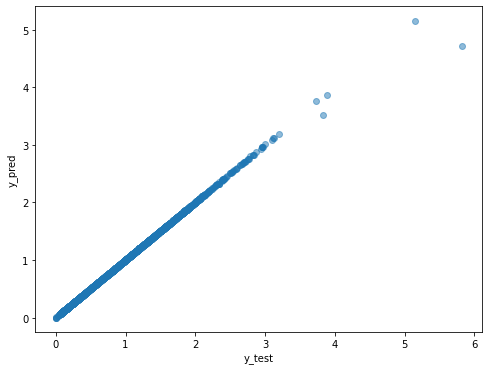

In [177]:
model.fit(Xtr,Ytr)
Ypred=model.predict(Xts)
lin_r = r2_score(Yts, Ypred)
# plotting actual vs prediction
plt.scatter(Yts, Ypred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [178]:
predictions = model.predict(test_set)
predictions

array([1.3856962 , 1.7139647 , 1.255728  , ..., 2.1278467 , 0.16979732,
       0.34494576], dtype=float32)

In [179]:
r2 = metrics.r2_score(Yts, Ypred)
r2

0.9987454476516002

Our model performs well on the test set. After comparison of the predicted Weight with the actual Weight we have an accuracy of 

##### 4.1 Feature importance

Now let's explore the feature importance on the model performance.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

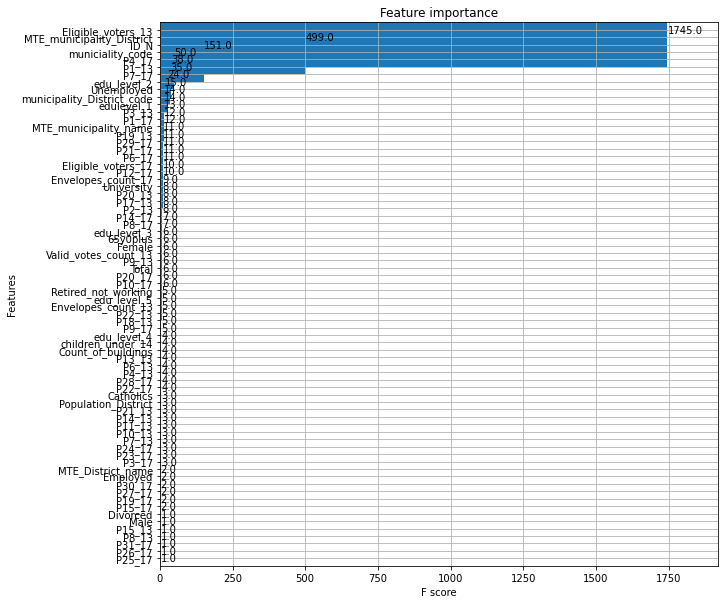

In [180]:
from xgboost import plot_importance
figsize=(10,10)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 10)

The most important features to the model are the eligible voters, the municipalities data the employment, the education, religion and some political partys scores.

#### 4.2 Hyperparameters research

We use so called fine tuning to find the best parameters for our model. We decide to use HalvingRandomSearchCV.

In [181]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import expon
import warnings
warnings.filterwarnings("ignore")

In [182]:
params_dist = [
    {
        'max_depth': [2, 3, 5, 8, 16], 
        'criterion': ['gini', 'entropy'],
        'min_samples_split': np.unique(np.logspace(1, 4, num=30, dtype=np.int)), 
        'ccp_alpha': expon(scale=0.00025),
        "learning_rate" : [0.05,0.10,0.15],
        "gamma": [ 0.0, 0.1, 0.2 ]
    }
]

tree = XGBRegressor(randon_state=RANDOM_STATE)

clf = HalvingRandomSearchCV(
    estimator=tree,
    param_distributions=params_dist,
    n_candidates=50,
    factor=2,
    resource='n_samples',
    min_resources='exhaust',
    cv=3,
    scoring='r2',
    error_score=0,
    refit=True,
    random_state=RANDOM_STATE
)

clf.fit(Xtr, Ytr)

[22:32:22] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "criterion", "min_samples_split", "randon_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:32:22] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "criterion", "min_samples_split", "randon_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:32:22] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "criterion", "min_samples_split", "randon_state" } might not be used.

  This could be a false alarm, with so

HalvingRandomSearchCV(cv=3, error_score=0,
                      estimator=XGBRegressor(base_score=None, booster=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             enable_categorical=False,
                                             gamma=None, gpu_id=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None,
                                             max_delta_step=None,
                                             max_depth=None,
                                             min_child_weight=None, missing=nan,
                                             mono...
                      param_distributions=[{'ccp_alpha': <scipy.sta

The hyperparameters reseacrh show that the best parameters for our modelling are following:

In [183]:
clf.best_params_

{'ccp_alpha': 0.00043575554549239335,
 'criterion': 'gini',
 'gamma': 0.0,
 'learning_rate': 0.15,
 'max_depth': 8,
 'min_samples_split': 16}

In [184]:
pd.DataFrame(clf.cv_results_).head()

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_gamma,param_learning_rate,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,295,0.15,4.16e-02,3.17e-03,1.42e-04,0.0,gini,0.1,0.1,5,20,"{'ccp_alpha': 4.185710574647497e-05, 'criterio...",1.0,0.35,0.96,0.77,0.30,38,1.00,1.00,1.0,1.00,6.98e-04
1,0,295,0.22,3.74e-03,3.41e-03,1.22e-04,0.0,gini,0.2,0.1,16,32,"{'ccp_alpha': 0.00032147817783043163, 'criteri...",1.0,0.34,0.96,0.77,0.30,67,0.99,0.99,1.0,0.99,1.27e-03
2,0,295,0.09,6.40e-03,3.16e-03,2.28e-04,0.0,gini,0.2,0.15,2,1487,"{'ccp_alpha': 8.498171963927468e-06, 'criterio...",1.0,0.34,0.96,0.77,0.30,72,0.99,0.99,1.0,0.99,1.62e-03
3,0,295,0.16,1.75e-03,3.08e-03,4.30e-05,0.0,entropy,0.2,0.1,8,25,"{'ccp_alpha': 0.00023290387994727609, 'criteri...",1.0,0.34,0.96,0.77,0.30,67,0.99,0.99,1.0,0.99,1.27e-03
4,0,295,0.12,2.98e-03,3.13e-03,4.45e-05,0.0,gini,0.0,0.15,5,452,"{'ccp_alpha': 0.00018413166651240812, 'criteri...",1.0,0.41,0.97,0.79,0.27,28,1.00,1.00,1.0,1.00,2.38e-07


In [185]:
cvres = pd.DataFrame(clf.cv_results_)

cvres.groupby('iter')['iter'].count()

iter
0    50
1    25
2    13
3     7
4     4
5     2
Name: iter, dtype: int64

Let's plot the results from the hyperparameters research and the r2_score at each iteration.

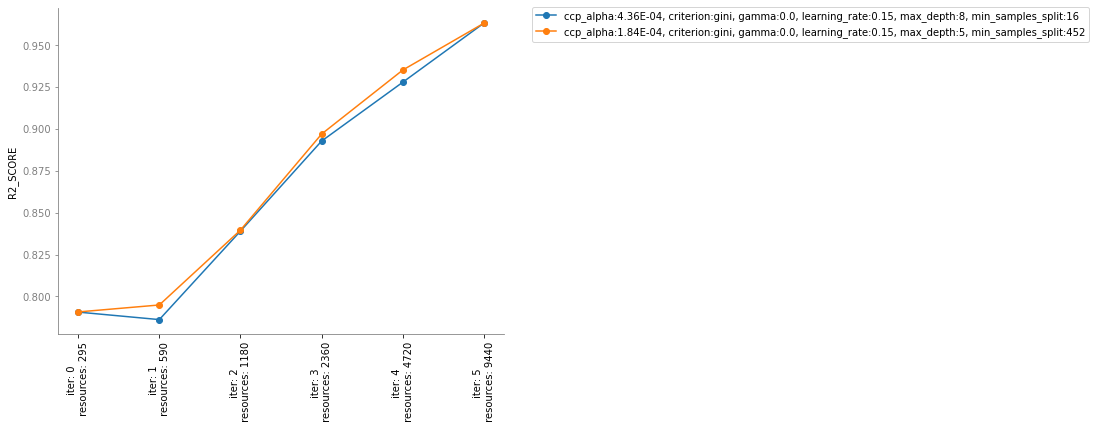

In [186]:
cvres = pd.DataFrame(clf.cv_results_)
param_combs = cvres[cvres['iter'] == 5]['params'].to_list()

cvres_res = pd.DataFrame()
ax = plt.subplot(1,1,1)
for pc in param_combs:
    dt = cvres[cvres['params'] == pc]
    label = ', '.join([f'{p}:{v:.2E}' if p=='ccp_alpha' else f'{p}:{v}' for p,v in pc.items()])
    ax.plot(dt['iter'], dt['mean_test_score'], marker='o', label=label)

ax.set_xticks(dt['iter'])
ax.set_xticklabels(
    cvres[['iter', 'n_resources']].drop_duplicates().apply(lambda row: f'iter: {row[0]}\n resources: {row[1]}', axis = 1).to_list(), 
    rotation=90
)

ax.legend(bbox_to_anchor=(1.05, 1.02))
ax.set_ylabel('R2_SCORE')
ax.tick_params(axis='y', colors='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.show()


In [187]:
xgb_model_tuned=clf
xgb_model_tuned.best_params_

{'ccp_alpha': 0.00043575554549239335,
 'criterion': 'gini',
 'gamma': 0.0,
 'learning_rate': 0.15,
 'max_depth': 8,
 'min_samples_split': 16}

#### 4.3 Final Model

After finetuning we build our final model using finetuned parameters.

In [188]:
from sklearn import metrics
#Validation data
val_data=data.drop(columns=col_target)
final_target=data[col_target]
predictions=xgb_model_tuned.predict(val_data)
r2 = metrics.r2_score(final_target, predictions)
r2

0.9930386733461537

The predictions on the validation set give an r2_score of 0.9919 which is excellent. Meaning our model predicts very well and is ready for use.

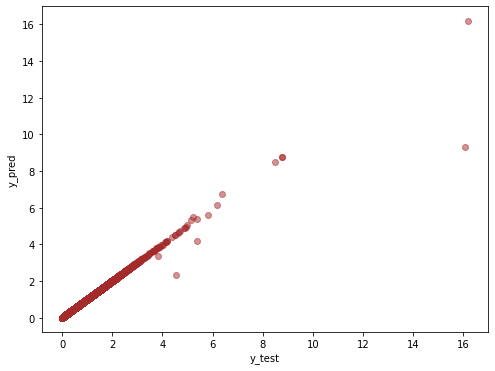

In [189]:
lin_r = metrics.r2_score(final_target, predictions)
# plotting actual vs prediction
plt.scatter(final_target, predictions, color="brown", alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

##### 6. Conclusion

The aim of this project was to explore and understanding the given dataset and learn from the data. We were able to find correlation between some features which are necessary to consider for next elections for a political party willing to do some predictions and terget their voters.
Using XGBoost regression we were able to build a powerful model to predict Weights with a  99% accuracy. 
This model is ready to be used and we highly recommend it.

Author: Doudou BA <br>
E-mail: presidou@gmail.com